In [1]:
import nltk
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
class GetFormattedDataset:
    def __init__(self):
        dataset = nltk.corpus.treebank.tagged_sents(tagset='universal')
        train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=42)
        train_set, dev_set = train_test_split(dataset, test_size=0.15, random_state=42)
        self.dataset = dict()
        self.dataset["x_train"] = [[d[0].lower() for d in data] for data in train_set]
        self.dataset["y_train"] = [[d[1] for d in data] for data in train_set]
        self.dataset["x_dev"] = [[d[0].lower() for d in data] for data in dev_set]
        self.dataset["y_dev"] = [[d[1] for d in data] for data in dev_set]
        self.dataset["x_test"] = [[d[0].lower() for d in data] for data in test_set]
        self.dataset["y_test"] = [[d[1] for d in data] for data in test_set]
        self.vocab = set([word for sentence in self.dataset["x_train"] for word in sentence])
        self.tags = set([tag for sentence in self.dataset["y_train"] for tag in sentence])

data_dict = GetFormattedDataset()

In [3]:
class Trainer:
    def __init__(self, data_dict: GetFormattedDataset, units=64, rnn="SimpleRNN") -> None:
        self.data_dict = data_dict
        self.rnn = rnn
        self.tokenizer = Tokenizer(num_words=15000, oov_token="[UNK]")
        self.tokenizer.fit_on_texts(data_dict.dataset["x_train"])
        self.tokenized_x_train = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_train"]), maxlen=100, padding="post")
        self.tokenized_x_dev = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_dev"]), maxlen=100, padding="post")
        self.tokenized_x_test = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_test"]), maxlen=100, padding="post")

        self.tag_tokenizer = Tokenizer()
        self.tag_tokenizer.fit_on_texts(data_dict.dataset["y_train"])
        self.tokenized_y_train = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_train"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)
        self.tokenized_y_dev = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_dev"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)
        self.tokenized_y_test = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_test"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)

        self.model = self.build_model(units)
        self.history = None

    def build_model(self, units):
        rnn_map = {
            "SimpleRNN": tf.keras.layers.SimpleRNN(units, return_sequences=True),
            "GRU": tf.keras.layers.GRU(units, return_sequences=True),
            "LSTM": tf.keras.layers.LSTM(units, return_sequences=True),
        }
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=15000, output_dim=32, input_length=100),
            rnn_map[self.rnn],
            tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(len(self.data_dict.tags) + 1,
                                      activation='softmax')
            )
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, batch_size=128, epochs=50):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True
        )
        self.history = self.model.fit(
            self.tokenized_x_train, self.tokenized_y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(self.tokenized_x_dev, self.tokenized_y_dev),
            callbacks=[early_stopping],
        )

Epoch 1/40
52/52 [==============================] - 4s 43ms/step - loss: 1.0643 - accuracy: 0.7282 - val_loss: 0.7268 - val_accuracy: 0.7535
Epoch 2/40
52/52 [==============================] - 2s 37ms/step - loss: 0.6462 - accuracy: 0.7935 - val_loss: 0.6129 - val_accuracy: 0.8103
Epoch 3/40
52/52 [==============================] - 3s 56ms/step - loss: 0.5651 - accuracy: 0.8208 - val_loss: 0.5609 - val_accuracy: 0.8234
Epoch 4/40
52/52 [==============================] - 2s 42ms/step - loss: 0.5141 - accuracy: 0.8373 - val_loss: 0.5067 - val_accuracy: 0.8432
Epoch 5/40
52/52 [==============================] - 2s 39ms/step - loss: 0.4476 - accuracy: 0.8729 - val_loss: 0.4288 - val_accuracy: 0.8879
Epoch 6/40
52/52 [==============================] - 2s 37ms/step - loss: 0.3611 - accuracy: 0.9083 - val_loss: 0.3374 - val_accuracy: 0.9155
Epoch 7/40
52/52 [==============================] - 2s 38ms/step - loss: 0.2738 - accuracy: 0.9339 - val_loss: 0.2569 - val_accuracy: 0.9370
Epoch 8/40
52

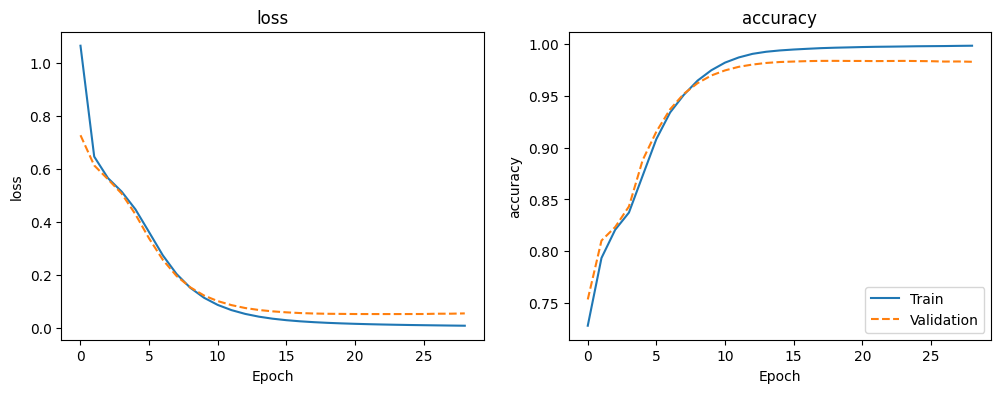

19/19 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9836
Test Loss: 0.052430007606744766 Test Accuracy (w/ padding): 0.9836394786834717
19/19 [==============================] - 0s 7ms/step


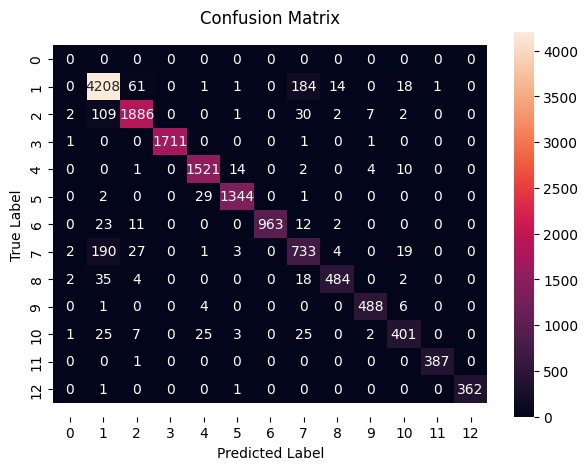

Test Accuracy (w/o padding): 0.9380989380989381


In [4]:
# Train using RNN
rnnTrainer = Trainer(data_dict, units=64)
rnnTrainer.train(batch_size=64, epochs=40)


# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(rnnTrainer.history.epoch, rnnTrainer.history.history[metric], label='Train')
    plt.plot(rnnTrainer.history.epoch, rnnTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = rnnTrainer.model.evaluate(rnnTrainer.tokenized_x_test, rnnTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(rnnTrainer.model.predict(rnnTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(rnnTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))

Epoch 1/40
52/52 [==============================] - 7s 79ms/step - loss: 1.3665 - accuracy: 0.7315 - val_loss: 0.7113 - val_accuracy: 0.7432
Epoch 2/40
52/52 [==============================] - 5s 92ms/step - loss: 0.6585 - accuracy: 0.7750 - val_loss: 0.6583 - val_accuracy: 0.7863
Epoch 3/40
52/52 [==============================] - 4s 74ms/step - loss: 0.6245 - accuracy: 0.8134 - val_loss: 0.6246 - val_accuracy: 0.8122
Epoch 4/40
52/52 [==============================] - 4s 71ms/step - loss: 0.5788 - accuracy: 0.8242 - val_loss: 0.5595 - val_accuracy: 0.8199
Epoch 5/40
52/52 [==============================] - 5s 92ms/step - loss: 0.4943 - accuracy: 0.8348 - val_loss: 0.4515 - val_accuracy: 0.8537
Epoch 6/40
52/52 [==============================] - 5s 91ms/step - loss: 0.3591 - accuracy: 0.9080 - val_loss: 0.2968 - val_accuracy: 0.9321
Epoch 7/40
52/52 [==============================] - 4s 72ms/step - loss: 0.2260 - accuracy: 0.9392 - val_loss: 0.1941 - val_accuracy: 0.9445
Epoch 8/40
52

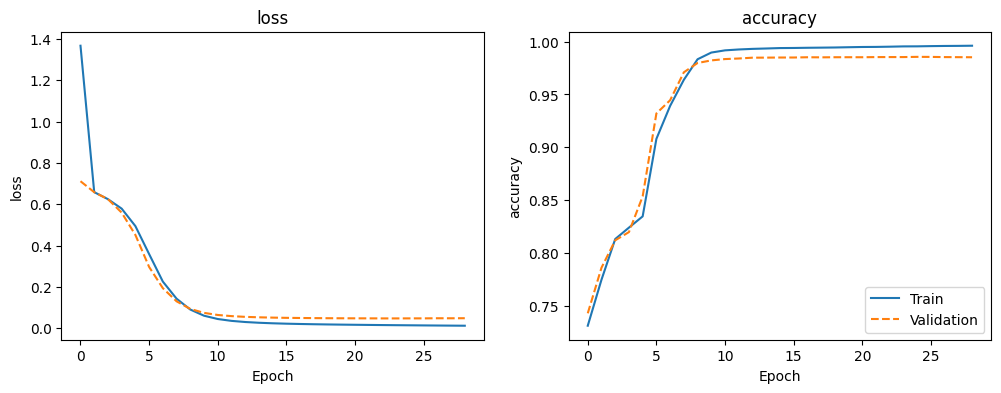

19/19 [==============================] - 0s 13ms/step - loss: 0.0479 - accuracy: 0.9853
Test Loss: 0.04791492596268654 Test Accuracy (w/ padding): 0.9853401184082031
19/19 [==============================] - 1s 11ms/step


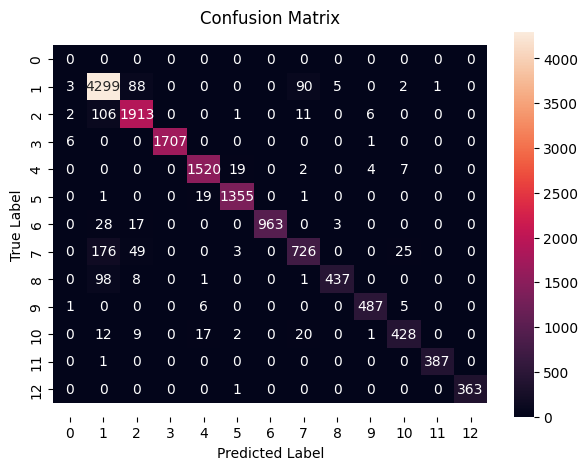

Test Accuracy (w/o padding): 0.9443796943796944


In [5]:
# Traing using GRU
gruTrainer = Trainer(data_dict, units=64, rnn="GRU")
gruTrainer.train(batch_size=64, epochs=40)




# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(gruTrainer.history.epoch, gruTrainer.history.history[metric], label='Train')
    plt.plot(gruTrainer.history.epoch, gruTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = gruTrainer.model.evaluate(gruTrainer.tokenized_x_test, gruTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(gruTrainer.model.predict(gruTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(gruTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))

Epoch 1/40
52/52 [==============================] - 7s 89ms/step - loss: 1.3201 - accuracy: 0.7294 - val_loss: 0.7685 - val_accuracy: 0.7432
Epoch 2/40
52/52 [==============================] - 4s 82ms/step - loss: 0.7040 - accuracy: 0.7615 - val_loss: 0.6894 - val_accuracy: 0.7573
Epoch 3/40
52/52 [==============================] - 5s 94ms/step - loss: 0.6531 - accuracy: 0.7781 - val_loss: 0.6559 - val_accuracy: 0.7863
Epoch 4/40
52/52 [==============================] - 4s 79ms/step - loss: 0.6184 - accuracy: 0.8099 - val_loss: 0.6141 - val_accuracy: 0.8133
Epoch 5/40
52/52 [==============================] - 5s 87ms/step - loss: 0.5802 - accuracy: 0.8209 - val_loss: 0.5822 - val_accuracy: 0.8218
Epoch 6/40
52/52 [==============================] - 5s 92ms/step - loss: 0.5522 - accuracy: 0.8261 - val_loss: 0.5569 - val_accuracy: 0.8232
Epoch 7/40
52/52 [==============================] - 4s 82ms/step - loss: 0.5250 - accuracy: 0.8287 - val_loss: 0.5222 - val_accuracy: 0.8287
Epoch 8/40
52

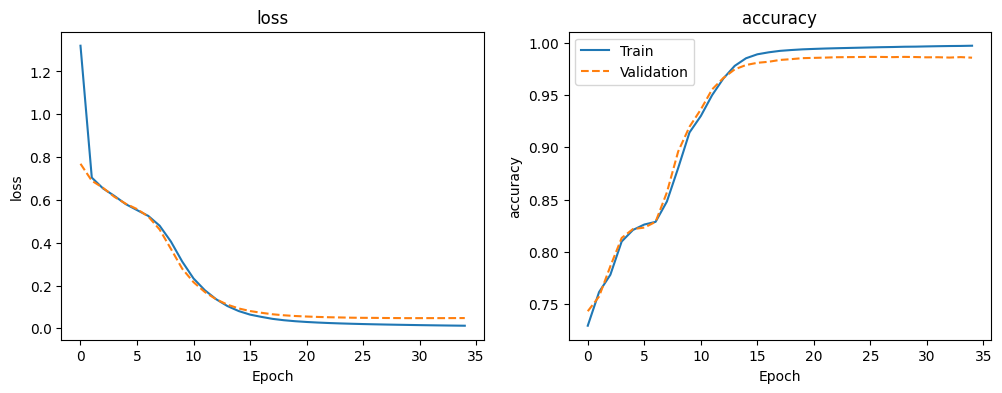

19/19 [==============================] - 1s 34ms/step - loss: 0.0475 - accuracy: 0.9862
Test Loss: 0.047501739114522934 Test Accuracy (w/ padding): 0.9861734509468079
19/19 [==============================] - 1s 33ms/step


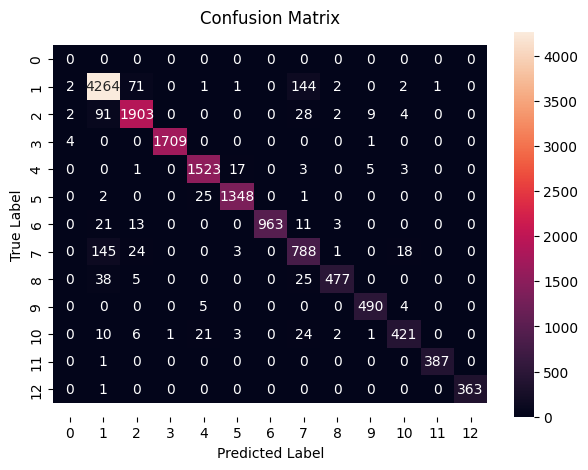

Test Accuracy (w/o padding): 0.9476819476819477


In [6]:
# Train using LSTM
lstmTrainer = Trainer(data_dict, units=64, rnn="LSTM")
lstmTrainer.train(batch_size=64, epochs=40)



# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(lstmTrainer.history.epoch, lstmTrainer.history.history[metric], label='Train')
    plt.plot(lstmTrainer.history.epoch, lstmTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = lstmTrainer.model.evaluate(lstmTrainer.tokenized_x_test, lstmTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(lstmTrainer.model.predict(lstmTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(lstmTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))